In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

from matplotlib.colors import ListedColormap

In [2]:
np.random.seed(42)

NAME = 'assignment4'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


In [ ]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2))
grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))


def Ising_model(J):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1, 41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*2*grid[i, j])

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

In [50]:
# Declare parameters
#---------------------------------------

def delta(i, j):
    return int(i == j)

def Cellular_Potts_model(
        J,                  # interaction strength matrix
        A,                  # equilibrium areas (should be -1 for the fluid)
        n_types = 3,        # number of cell types (including fluid medium)
        n_cells = 1000,     # number of different cells (cell ids)
        n_steps = 10001,    # number of simulation steps
        nx = 100,           # size of the grid side
        T = 1,              # temperature
        k = 1,              # "Boltzmann constant"
        lam = 1,            # lambda parameter,
    ):

    assert J.shape == (n_types, n_types)
    assert A.shape == (n_types, ) and A[0] == -1
    assert T > 0

    # Type-recognizing function
    celltype = lambda sigma : (sigma % n_types)

    # Create grid of cell ids with continuous boundaries
    grid = np.random.randint(0, n_cells, (nx, nx))

    # Store cell areas
    _, areas = np.unique(grid, return_counts=True)
    
    # Create list to store Magnetization modulus
    # M = np.zeros(n_steps + 1)

    # Moore neighbourhood
    von_neumann_neighbourhood = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]])
    
    for step in range(n_steps):
        
        # Calculate magnetization
        # M[step:] += abs(np.sum(grid))

        # Randomly choose lattice site 
        i, j = np.random.randint(0, nx, 2)
        sigma = grid[i,j]
        tau = celltype(sigma)

        # Randomly choose a neighbour
        ip, jp = von_neumann_neighbourhood[np.random.randint(4)]
        iprime, jprime = (i + ip) % nx, (j + jp) % nx

        sigma_prime = grid[iprime, jprime]
        tau_prime = celltype(sigma_prime)

        # Change in volumetric energy
        a_sigma = areas[sigma]
        a_sigma_prime = areas[sigma_prime]

        A_sigma = A[tau]
        A_sigma_prime = A[tau_prime]

        delta_Hvol = -1
        if sigma == sigma_prime:
            delta_Hvol = 0
        elif (sigma != 0 and sigma_prime != 0):
            delta_Hvol = lam * (((a_sigma - 1 - A_sigma)**2 + (a_sigma_prime + 1 - A_sigma_prime)**2) -
                                ((a_sigma - A_sigma)**2 + (a_sigma_prime - A_sigma_prime)**2))
        elif (sigma == 0):
            delta_Hvol = lam * ((a_sigma_prime + 1 - A_sigma_prime)**2 -
                                (a_sigma_prime - A_sigma_prime)**2)
        elif (sigma_prime == 0):
            delta_Hvol = lam * ((a_sigma - 1 - A_sigma)**2 -
                                (a_sigma - A_sigma)**2)
        
        # Change in bond energy
        delta_Hbond = (
                       J[tau_prime, celltype(grid[i-1,          j-1         ])] * (1 - delta(sigma_prime, grid[i-1,          j-1         ])) +
                       J[tau_prime, celltype(grid[i,            j-1         ])] * (1 - delta(sigma_prime, grid[i,            j-1         ])) +
                       J[tau_prime, celltype(grid[(i+1) % nx,   j-1         ])] * (1 - delta(sigma_prime, grid[(i+1) % nx,   j-1         ])) +
                       J[tau_prime, celltype(grid[(i+1) % nx,   j           ])] * (1 - delta(sigma_prime, grid[(i+1) % nx,   j           ])) +
                       J[tau_prime, celltype(grid[(i+1) % nx,   (j+1) % nx  ])] * (1 - delta(sigma_prime, grid[(i+1) % nx,   (j+1) % nx  ])) +
                       J[tau_prime, celltype(grid[i,            (j+1) % nx  ])] * (1 - delta(sigma_prime, grid[i,            (j+1) % nx  ])) +
                       J[tau_prime, celltype(grid[i-1,          (j+1) % nx  ])] * (1 - delta(sigma_prime, grid[i-1,          (j+1) % nx  ])) +
                       J[tau_prime, celltype(grid[i-1,          j           ])] * (1 - delta(sigma_prime, grid[i-1,          j           ]))
                       ) - (
                       J[tau, celltype(grid[i-1,          j-1         ])] * (1 - delta(sigma, grid[i-1,          j-1         ])) +
                       J[tau, celltype(grid[i,            j-1         ])] * (1 - delta(sigma, grid[i,            j-1         ])) +
                       J[tau, celltype(grid[(i+1) % nx,   j-1         ])] * (1 - delta(sigma, grid[(i+1) % nx,   j-1         ])) +
                       J[tau, celltype(grid[(i+1) % nx,   j           ])] * (1 - delta(sigma, grid[(i+1) % nx,   j           ])) +
                       J[tau, celltype(grid[(i+1) % nx,   (j+1) % nx  ])] * (1 - delta(sigma, grid[(i+1) % nx,   (j+1) % nx  ])) +
                       J[tau, celltype(grid[i,            (j+1) % nx  ])] * (1 - delta(sigma, grid[i,            (j+1) % nx  ])) +
                       J[tau, celltype(grid[i-1,          (j+1) % nx  ])] * (1 - delta(sigma, grid[i-1,          (j+1) % nx  ])) +
                       J[tau, celltype(grid[i-1,          j           ])] * (1 - delta(sigma, grid[i-1,          j           ]))
                       )
        
        # Total change
        H = delta_Hvol + delta_Hbond
        
        # Update grid
        if H <= 0:
            grid[i, j] = grid[iprime, jprime]
            areas[sigma] -= 1
            areas[sigma_prime] += 1
        else:
            P = np.exp(-H/(k*T))
            if P > np.random.sample():
                grid[i, j] = grid[iprime, jprime]
                areas[sigma] -= 1
                areas[sigma_prime] += 1

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(8,8), dpi=80)
 
    # ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    # # ax.plot(M / (np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    # ax.grid(b=True, which='major', c='k', alpha=0.2)
    # ax.set_xlabel('n')
    # ax.set_ylabel('<|M|>')
    # ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 1), (0, 0))
    ax.grid()

    # Yeah it will only work for two cell types + surrounding fluid, whoopsie
    # TODO: Generalize the implementation for multiple celltypes
    celltype_grid = celltype(grid)

    cmap = ListedColormap(['white', 'dimgray', 'gold'])
    ax.matshow(celltype_grid, cmap=cmap)
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

In [52]:
# Cell type equilibrium areas
ntypes = 3
A = np.zeros(ntypes)

# Based on section II.A2. in the paper
# to be fair, our implementation doesn't even use that value
# TODO: Change later
A[0] = -1

# Based on section II.B1. in the paper
A[1] = 40
A[2] = 40

# Also based on that section, but scaled down
nx = 100
ncells = 20

# Based on section III.A2. in the paper
J_MM = 0
J_ll = 10
J_dd = 8
J_ld = 6
J_lM = 12
J_dM = 12

T = 10
lam = 1

# 0: the surrounding fluid (M in the paper)
# 1: low surface energy 'dark' cells (d in the paper)
# 2: high surface energy 'light' cells (l in the paper)
J = np.array([
    [J_MM, J_dM, J_lM,],
    [J_dM, J_dd, J_ld,],
    [J_lM, J_ld, J_ll,],
])

# Other simulation parameters
n_steps = 100000
k = 1

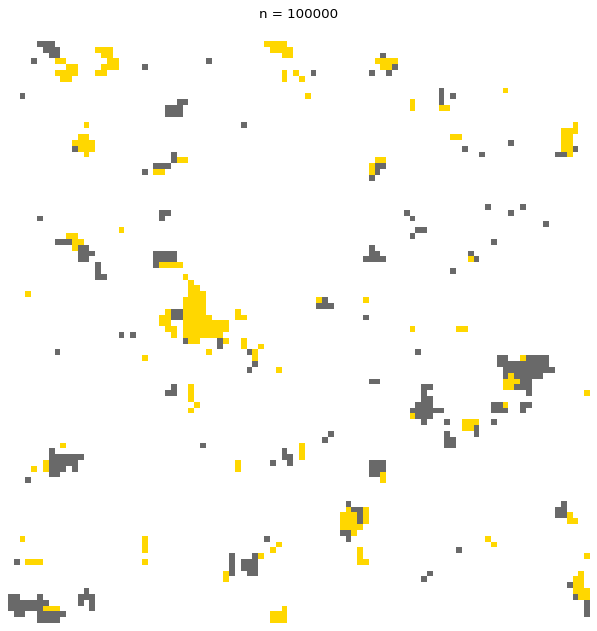

In [53]:
Cellular_Potts_model(J, A, ntypes, ncells, n_steps, nx, T, k, lam)